# notebook imagenette
The basis is kaiming initialization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## Imagenette data

In [4]:
#path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path = Path("/Users/kasparlund/.fastai/data/imagenette-160")

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
in_features  = 3
out_features = max(ll.train.y)+1

train_dl,valid_dl = ( DataLoader(ll.train, batch_size=bs,   num_workers=4, shuffle=True),
                      DataLoader(ll.valid, batch_size=bs*2, num_workers=4))
data = DataBunch(train_dl, valid_dl)
print(len(train_dl))

101


In [6]:
layers_sizes = [32,64,128,256,512]

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#        partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
        
        #CudaCallback,
        ProgressCallback,
       ]
cbfs = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy])]
cbfs_lr_Finder = cbfs_base.copy() + [LR_Finder]

## steppers=[sgd_step]

In [7]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=SGD(sched,max_lr=0.1), cb_funcs=cbfs)
%time learn.fit(1)

train: [1.9894712414689002, tensor(0.3057)]
valid: [1.8029927978515625, tensor(0.3840)]
CPU times: user 6min 47s, sys: 1min 11s, total: 7min 59s
Wall time: 1min 36s


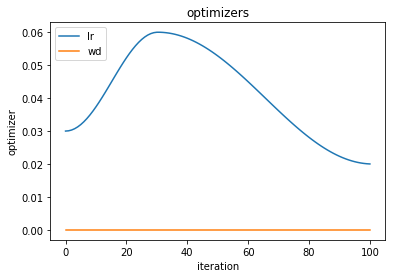

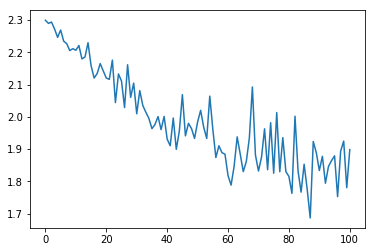

(None, None)

In [8]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## steppers=[weight_decay, sgd_step]

In [9]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=SGD(sched,max_lr=0.1, max_wd=1e-4), cb_funcs=cbfs)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
%time learn.fit(1)

train: [1.9713152374651, tensor(0.3130)]
valid: [1.7792911376953124, tensor(0.3900)]
CPU times: user 6min 37s, sys: 1min 10s, total: 7min 48s
Wall time: 1min 33s


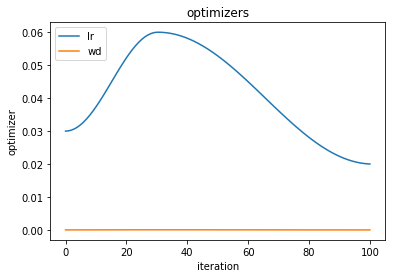

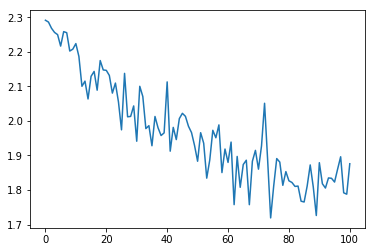

(None, None)

In [10]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [11]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                opt=SGD_Momentum(sched,max_lr=0.08, moms=(0.85,0.95), max_wd=1e-4 ), cb_funcs=cbfs)
%time learn.fit(1)

train: [2.01936674761517, tensor(0.2814)]
valid: [1.821083251953125, tensor(0.3880)]
CPU times: user 6min 44s, sys: 1min 13s, total: 7min 58s
Wall time: 1min 38s


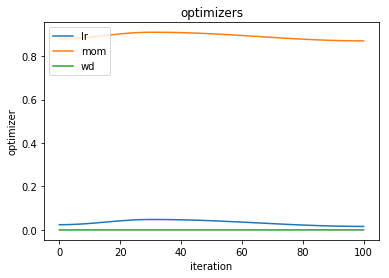

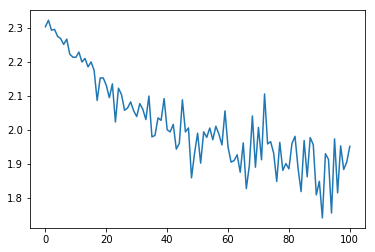

(None, None)

In [12]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam: steppers=[adam_step]

In [29]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                 opt=Adam(sched,max_lr=1e-3, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)
%time learn.fit(3)

train: [1.7185126379032885, tensor(0.4179)]
valid: [1.384413818359375, tensor(0.5440)]
train: [1.27269208910152, tensor(0.5914)]
valid: [1.1369345703125, tensor(0.6220)]
train: [1.0329963609527688, tensor(0.6743)]
valid: [1.0381173095703125, tensor(0.6620)]
CPU times: user 20min 31s, sys: 3min 49s, total: 24min 21s
Wall time: 4min 57s


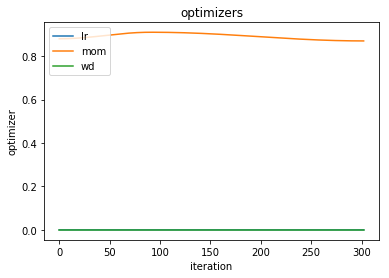

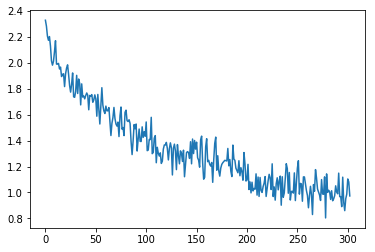

(None, None)

In [30]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## LAMB: steppers=[lamb_step]

In [31]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy,
                 opt=LAMB(sched,max_lr=3e-3, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)
%time learn.fit(3)

train: [1.7748089591088878, tensor(0.3967)]
valid: [1.424211669921875, tensor(0.5320)]
train: [1.308142353032418, tensor(0.5745)]
valid: [1.1798597412109375, tensor(0.6240)]
train: [1.0781242426225377, tensor(0.6567)]
valid: [1.04868115234375, tensor(0.6700)]
CPU times: user 20min 8s, sys: 3min 52s, total: 24min 1s
Wall time: 4min 46s


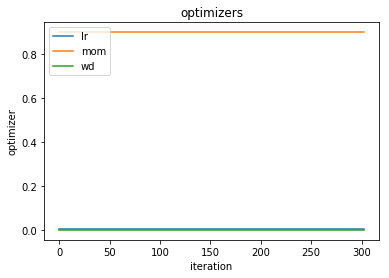

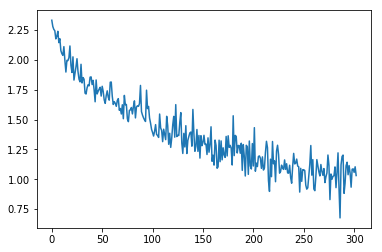

(None, None)

In [32]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=17),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam with hooks

train: [1.9424706682856367, tensor(0.3238)]
valid: [1.714045654296875, tensor(0.4460)]


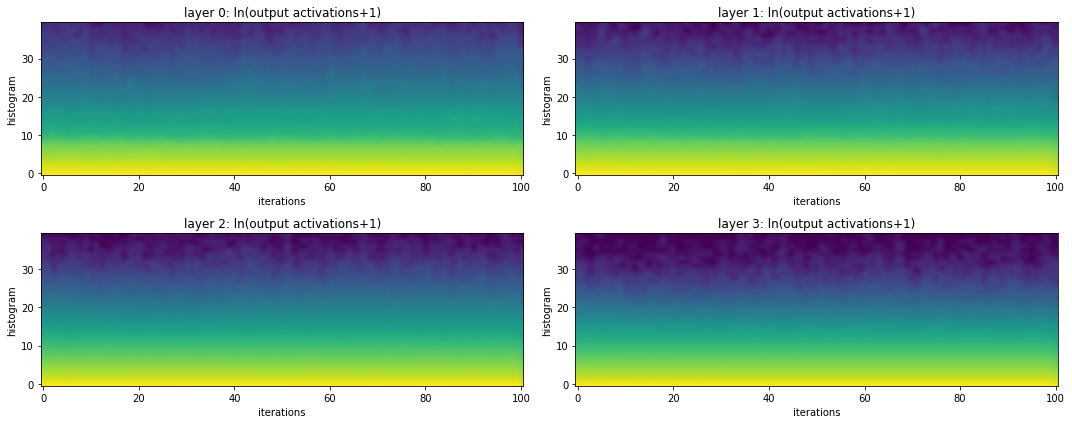

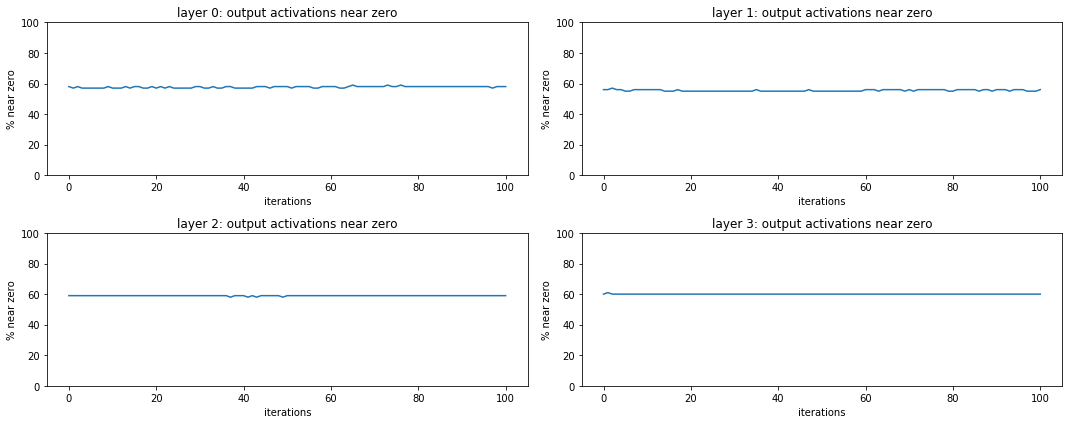

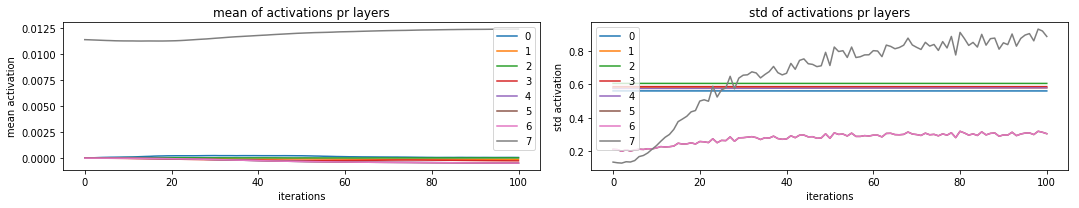

In [17]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                 opt=Adam(sched,max_lr=2e-4, moms=(0.85,0.95), max_wd = 1e-4), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )

## LAMB with hooks

train: [1.7241101117767954, tensor(0.4059)]
valid: [1.754093505859375, tensor(0.4440)]


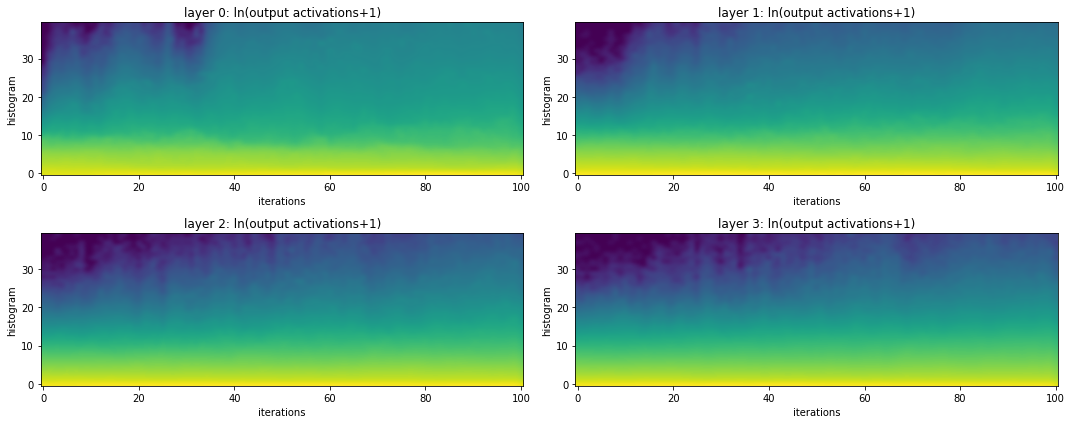

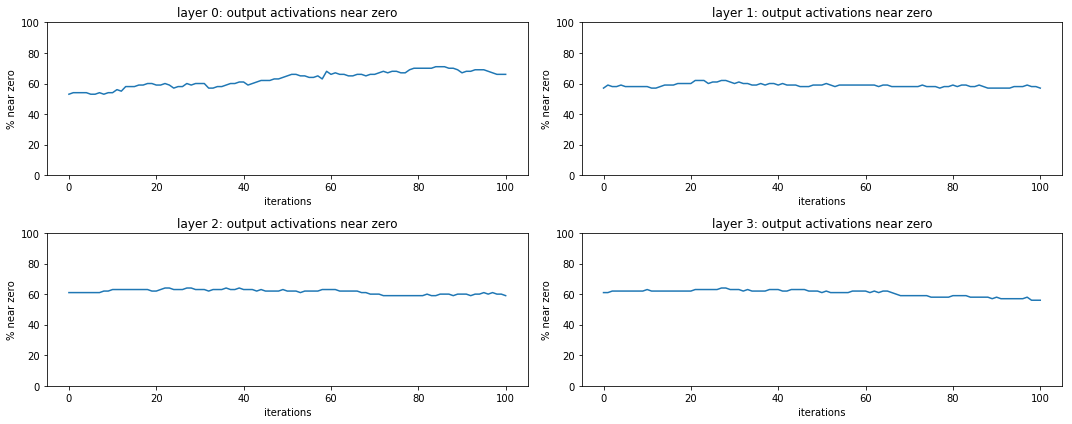

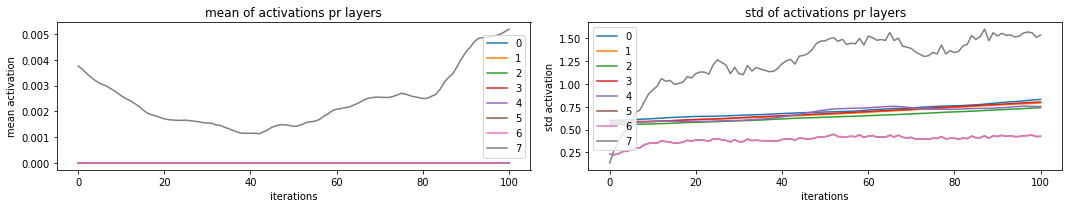

In [18]:
model = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                 opt=LAMB(sched,max_lr=1e-2, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )